In [1]:
# Run in Colab: uncomment the pip install line if not already installed.
!pip install pandas openpyxl deap torch scikit-learn seaborn tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.1 MB/s eta 0:00:00


In [2]:
#  INSTALL & IMPORTS
import os, random, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from deap import base, creator, tools, algorithms

sns.set(style="whitegrid")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [3]:
# CONFIG & DRIVE MOUNT (Colab)
# If using Colab, mount drive and set these paths:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p "/content/drive/MyDrive/NNsGA"

DATA_PATH = "/content/drive/MyDrive/PINNs/Suction_vsCP-modified_1.xlsx"
SAVE_PATH = "/content/drive/MyDrive/NNsGA/best_ga_ann_gui_ready_full.pth"
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED); random.seed(RANDOM_SEED); torch.manual_seed(RANDOM_SEED)


Mounted at /content/drive


In [4]:
# DATA LOADING & SCALERS
df = pd.read_excel(DATA_PATH)
feature_names = df.columns[:-1].tolist()
target_name = df.columns[-1]
print("Features:", feature_names)
print("Target:", target_name)

X = df.iloc[:, :-1].values.astype(float)
y = df.iloc[:, -1].values.astype(float).reshape(-1, 1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y).flatten()

# Train/Val/Test split ~ 70/15/15
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y_scaled, test_size=0.15, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.17647, random_state=RANDOM_SEED)

# # First split: 5% test, 95% train+val
# X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y_scaled, test_size=0.05, random_state=RANDOM_SEED) # 5% test
# # Second split: 15% validation (of original data) ≈ 15.79% of remaining 95%
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1579,random_state=RANDOM_SEED) # 15% val (0.15 / 0.95 ≈ 0.1579)


# Torch tensors
X_tr_tensor   = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
y_tr_tensor   = torch.tensor(y_train, dtype=torch.float32).view(-1,1).to(DEVICE)
X_val_tensor  = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
y_val_tensor  = torch.tensor(y_val, dtype=torch.float32).view(-1,1).to(DEVICE)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1,1).to(DEVICE)

INPUT_DIM = X.shape[1]
print(f"Train/Val/Test sizes: {len(X_train)}/{len(X_val)}/{len(X_test)}")

Features: ['Suction (kPa)', 'Silica fume (%)', 'Lime (%)', 'Gypsum content (%)', 'Applied vertical stress (kPa)', 'Degree of Saturation (%)']
Target: Collapse Potential (%)
Train/Val/Test sizes: 420/90/90


In [5]:
# CELL 4: MODEL CLASSES
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.out = nn.Linear(hidden2, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

class ANNModelDropout(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, p_drop=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.do1 = nn.Dropout(p_drop)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.do2 = nn.Dropout(p_drop)
        self.out = nn.Linear(hidden2, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.do1(x)
        x = torch.relu(self.fc2(x))
        x = self.do2(x)
        return self.out(x)

In [6]:
# GA SETUP + EVALUATION FUNCTION
# Avoid duplicate creator on re-run
if not hasattr(creator, "FitnessMin"):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
if not hasattr(creator, "Individual"):
    creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_h1", random.randint, 4, 64)
toolbox.register("attr_h2", random.randint, 4, 64)
toolbox.register("attr_lr", random.uniform, 0.0005, 0.01)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_h1, toolbox.attr_h2, toolbox.attr_lr), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate_individual(ind):
    h1, h2, lr = int(ind[0]), int(ind[1]), float(ind[2])
    model = ANNModel(INPUT_DIM, h1, h2).to(DEVICE)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = nn.MSELoss()
    model.train()
    for _ in range(200):
        opt.zero_grad()
        out = model(X_tr_tensor)
        loss = crit(out, y_tr_tensor)
        loss.backward()
        opt.step()
    model.eval()
    with torch.no_grad():
        pred = model(X_val_tensor).cpu().numpy()
    mse = mean_squared_error(y_val, pred)
    return (mse,)

toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutPolynomialBounded,
                 low=[4,4,0.0005], up=[64,64,0.01], eta=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

In [7]:
# RUN GA (convergence tracking)
GA_POP=30; GA_NGEN=30
pop = toolbox.population(n=GA_POP)
hof = tools.HallOfFame(1)

# init fitness
for ind in pop:
    ind.fitness.values = toolbox.evaluate(ind)

ga_hist = {'gen':[], 'best':[], 'avg':[], 'worst':[]}
for gen in range(GA_NGEN):
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))
    # crossover
    for c1,c2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.6:
            toolbox.mate(c1, c2)
            del c1.fitness.values; del c2.fitness.values
    # mutation
    for m in offspring:
        if random.random() < 0.3:
            toolbox.mutate(m)
            del m.fitness.values
    # evaluate invalid
    invalid = [ind for ind in offspring if not ind.fitness.valid]
    for ind in invalid:
        ind.fitness.values = toolbox.evaluate(ind)
    pop[:] = offspring
    hof.update(pop)
    fits = [ind.fitness.values[0] for ind in pop]
    ga_hist['gen'].append(gen)
    ga_hist['best'].append(np.min(fits))
    ga_hist['avg'].append(np.mean(fits))
    ga_hist['worst'].append(np.max(fits))
    if (gen+1)%5==0 or gen==0:
        print(f"Gen {gen+1}/{GA_NGEN} best={ga_hist['best'][-1]:.6f} avg={ga_hist['avg'][-1]:.6f}")

best_ind = hof[0]; best_h1, best_h2, best_lr = int(best_ind[0]), int(best_ind[1]), float(best_ind[2])
print("GA best:", best_ind)

Gen 1/30 best=0.000317 avg=0.003639
Gen 5/30 best=0.000244 avg=0.000792
Gen 10/30 best=0.000244 avg=0.000807
Gen 15/30 best=0.000249 avg=0.000887
Gen 20/30 best=0.000310 avg=0.000879
Gen 25/30 best=0.000304 avg=0.000713
Gen 30/30 best=0.000312 avg=0.000632
GA best: [43, 48, 0.008686215552952384]


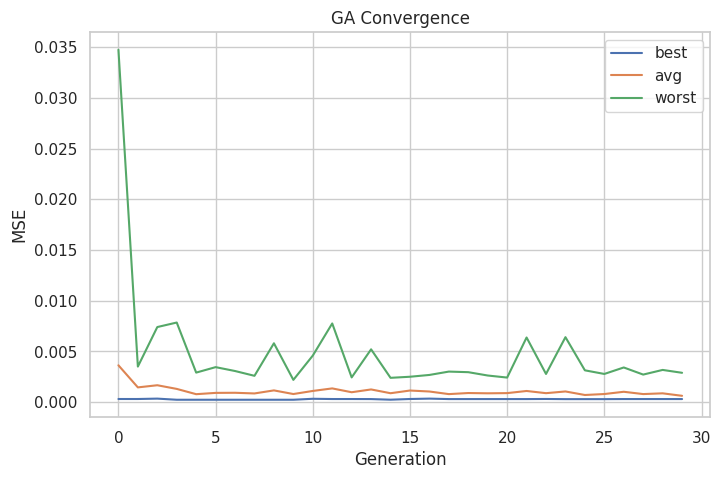

In [8]:
# PLOT GA CONVERGENCE
plt.figure(figsize=(8,5))
plt.plot(ga_hist['gen'], ga_hist['best'], label='best')
plt.plot(ga_hist['gen'], ga_hist['avg'], label='avg')
plt.plot(ga_hist['gen'], ga_hist['worst'], label='worst')
plt.xlabel("Generation"); plt.ylabel("MSE"); plt.title("GA Convergence"); plt.legend(); plt.grid(True); plt.show()

Final training: 100%|██████████| 500/500 [00:00<00:00, 557.91it/s]


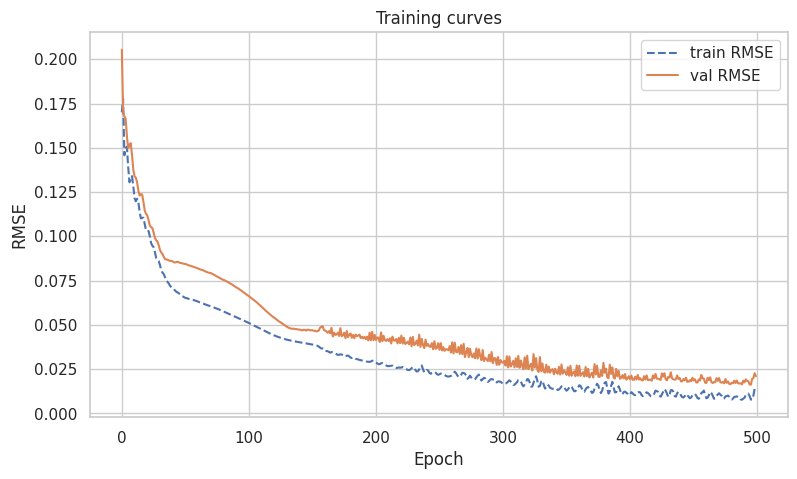

Test RMSE=3.9872 R2=0.9381


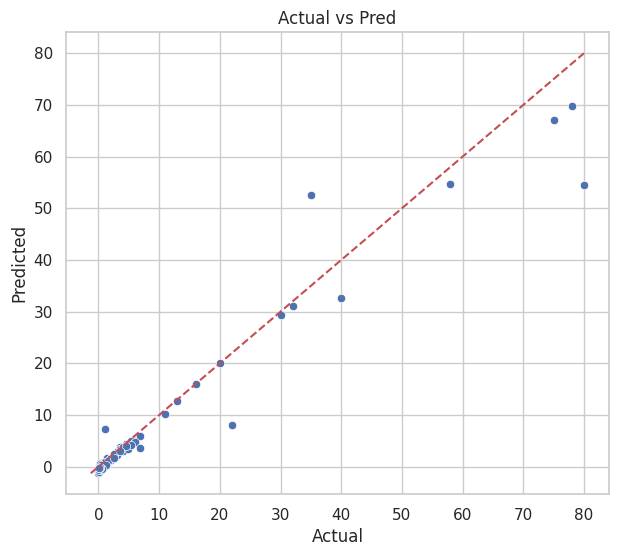

In [10]:
# TRAIN FINAL MODEL (with best params)
final_model = ANNModel(INPUT_DIM, best_h1, best_h2).to(DEVICE)
opt = optim.Adam(final_model.parameters(), lr=best_lr)
crit = nn.MSELoss()
EPOCHS_FINAL = 500
train_losses, val_losses = [], []
for ep in trange(EPOCHS_FINAL, desc="Final training"):
    final_model.train()
    opt.zero_grad()
    out = final_model(X_tr_tensor)
    loss = crit(out, y_tr_tensor)
    loss.backward()
    opt.step()
    train_losses.append(loss.item())
    final_model.eval()
    with torch.no_grad():
        v = final_model(X_val_tensor)
        val_losses.append(crit(v, y_val_tensor).item())

plt.figure(figsize=(9,5))
plt.plot(np.sqrt(train_losses), linestyle='--', label='train RMSE')
plt.plot(np.sqrt(val_losses), label='val RMSE')
plt.xlabel("Epoch"); plt.ylabel("RMSE"); plt.title("Training curves"); plt.legend(); plt.grid(True); plt.show()

# Test evaluation
final_model.eval()
with torch.no_grad():
    preds_scaled = final_model(X_test_tensor).cpu().numpy().flatten()
    preds = scaler_y.inverse_transform(preds_scaled.reshape(-1,1)).flatten()
    actuals = scaler_y.inverse_transform(y_test.reshape(-1,1)).flatten()
mse_test = mean_squared_error(actuals, preds); rmse_test = np.sqrt(mse_test); r2_test = r2_score(actuals, preds)
print(f"Test RMSE={rmse_test:.4f} R2={r2_test:.4f}")
plt.figure(figsize=(7,6)); sns.scatterplot(x=actuals, y=preds); mn=min(min(actuals),min(preds)); mx=max(max(actuals),max(preds))
plt.plot([mn,mx],[mn,mx],'r--'); plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("Actual vs Pred"); plt.show()

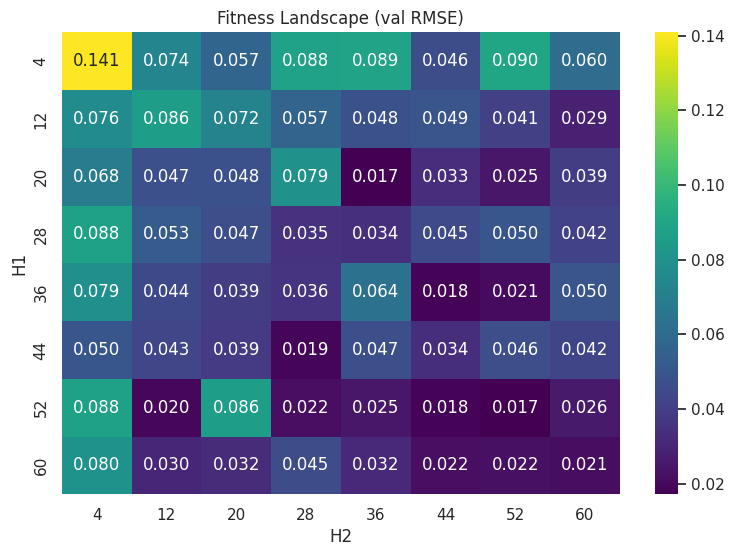

In [11]:
# FITNESS LANDSCAPE (H1 x H2 heatmap, LR fixed)
h1_vals = list(range(4,65,8)); h2_vals = list(range(4,65,8))
fitness_heat = np.zeros((len(h1_vals), len(h2_vals)))
for i,h1 in enumerate(h1_vals):
    for j,h2 in enumerate(h2_vals):
        temp = ANNModel(INPUT_DIM, h1, h2).to(DEVICE)
        topt = optim.Adam(temp.parameters(), lr=best_lr)
        tcrit = nn.MSELoss()
        temp.train()
        for _ in range(200):
            topt.zero_grad(); out = temp(X_tr_tensor); l = tcrit(out, y_tr_tensor); l.backward(); topt.step()
        temp.eval()
        with torch.no_grad():
            p = temp(X_val_tensor).cpu().numpy()
        fitness_heat[i,j] = np.sqrt(mean_squared_error(y_val, p))
plt.figure(figsize=(9,6)); sns.heatmap(fitness_heat, xticklabels=h2_vals, yticklabels=h1_vals, annot=True, fmt=".3f", cmap="viridis")
plt.title("Fitness Landscape (val RMSE)"); plt.xlabel("H2"); plt.ylabel("H1"); plt.show()

Top 10 variants (lowest RMSE):
      H1  H2        LR      RMSE
61   43  48  0.007818  0.018117
101  51  38  0.007818  0.018167
98   47  57  0.009555  0.018171
29   38  38  0.010423  0.018929
24   34  57  0.010423  0.018957
69   43  52  0.010423  0.019053
67   43  52  0.008686  0.019206
68   43  52  0.009555  0.019266
1    34  38  0.007818  0.019303
45   38  57  0.006949  0.019366


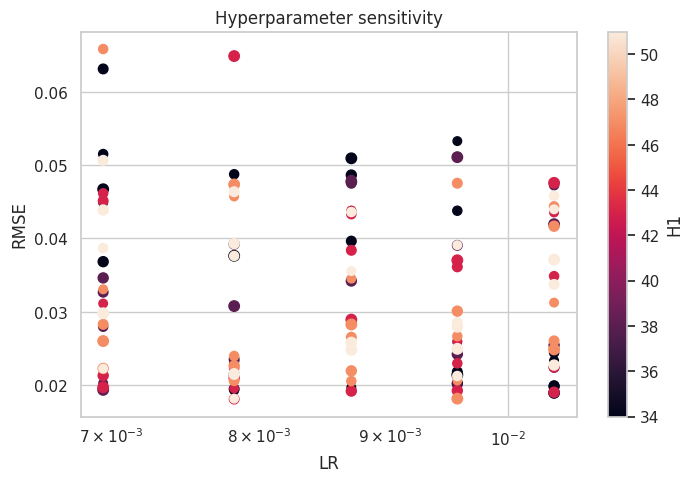

In [12]:
# HYPERPARAMETER SENSITIVITY (±20%) & visualization
variations = [-0.2,-0.1,0.0,0.1,0.2]
sens_results = []
for dh1 in variations:
    for dh2 in variations:
        for dlr in variations:
            h1 = max(4, int(best_h1*(1+dh1))); h2 = max(4, int(best_h2*(1+dh2))); lr = max(1e-6, best_lr*(1+dlr))
            temp = ANNModel(INPUT_DIM, h1, h2).to(DEVICE)
            topt = optim.Adam(temp.parameters(), lr=lr); tcrit = nn.MSELoss()
            temp.train()
            for _ in range(200):
                topt.zero_grad(); out = temp(X_tr_tensor); l=tcrit(out, y_tr_tensor); l.backward(); topt.step()
            temp.eval()
            with torch.no_grad():
                p = temp(X_val_tensor).cpu().numpy()
            sens_results.append((h1,h2,lr,np.sqrt(mean_squared_error(y_val,p))))
sens_df = pd.DataFrame(sens_results, columns=["H1","H2","LR","RMSE"])
print("Top 10 variants (lowest RMSE):\n", sens_df.sort_values("RMSE").head(10))
plt.figure(figsize=(8,5)); plt.scatter(sens_df['LR'], sens_df['RMSE'], c=sens_df['H1'], s=sens_df['H2'])
plt.xscale('log'); plt.colorbar(label='H1'); plt.xlabel("LR"); plt.ylabel("RMSE"); plt.title("Hyperparameter sensitivity"); plt.show()

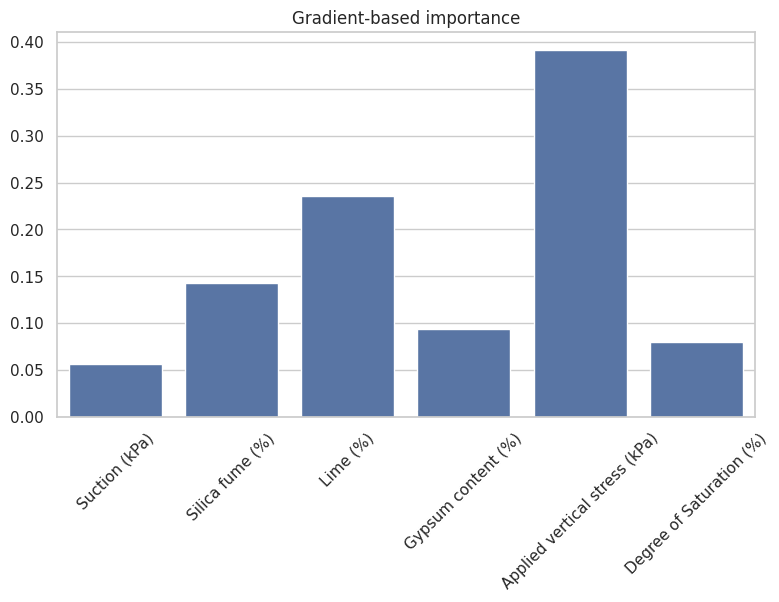

In [16]:
# GRADIENT-BASED FEATURE IMPORTANCE
final_model.eval()
X_test_req = torch.tensor(X_test, dtype=torch.float32, requires_grad=True).to(DEVICE)
X_test_req.retain_grad() # Retain gradients for non-leaf tensor
out_test = final_model(X_test_req)
loss_scalar = out_test.mean()
final_model.zero_grad()
if X_test_req.grad is not None:
    X_test_req.grad.zero_()
loss_scalar.backward()
grads = X_test_req.grad.detach().cpu().abs().mean(axis=0).numpy()
grads_norm = grads / (grads.sum() + 1e-12)
plt.figure(figsize=(9,5)); sns.barplot(x=feature_names, y=grads_norm); plt.xticks(rotation=45); plt.title("Gradient-based importance"); plt.show()

ICE for: Suction (kPa)


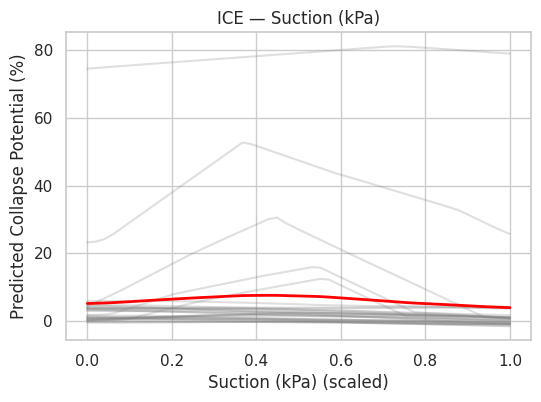

ICE for: Silica fume (%)


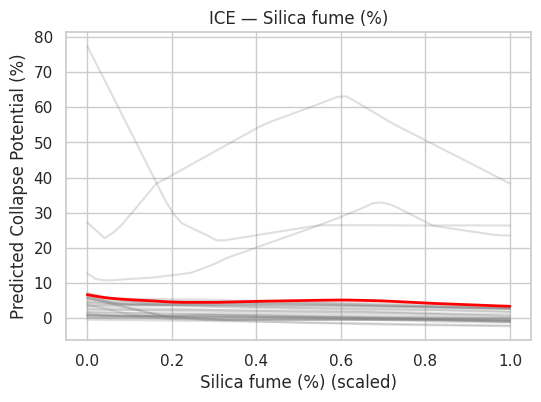

ICE for: Lime (%)


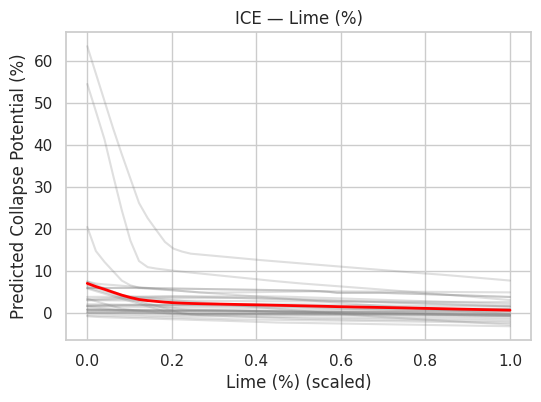

ICE for: Gypsum content (%)


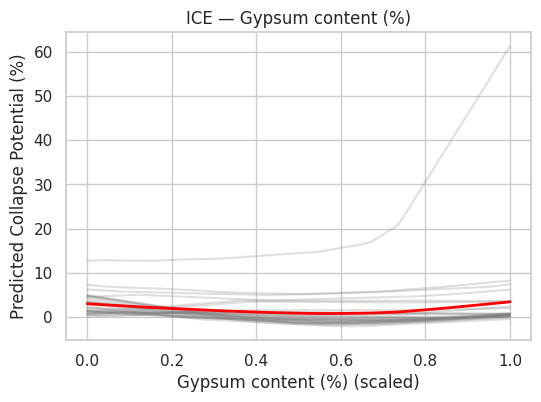

ICE for: Applied vertical stress (kPa)


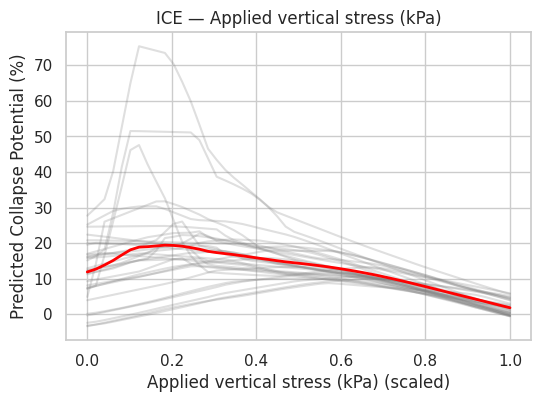

ICE for: Degree of Saturation (%)


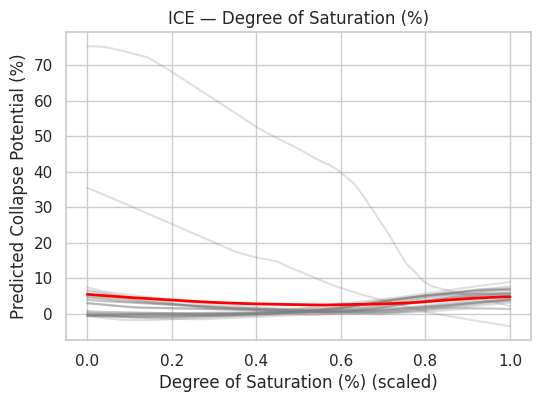

In [20]:
# ICE PLOTS (for each feature)
def plot_ice(model, X_scaled_all, feat_idx, feat_name, n_points=150, n_curves=30):
    Xbase = X_scaled_all.copy()
    vals = np.linspace(Xbase[:, feat_idx].min(), Xbase[:, feat_idx].max(), n_points)
    idxs = np.random.choice(range(Xbase.shape[0]), size=min(n_curves, Xbase.shape[0]), replace=False)
    curves = []
    for i in idxs:
        row = Xbase[i:i+1].copy()
        preds=[]
        for v in vals:
            row_temp = row.copy(); row_temp[0,feat_idx]=v
            with torch.no_grad():
                out = model(torch.tensor(row_temp, dtype=torch.float32).to(DEVICE)).cpu().numpy().flatten()
            preds.append(scaler_y.inverse_transform(out.reshape(-1,1)).flatten()[0])
        curves.append(preds)
    mean_curve = np.mean(curves, axis=0)
    plt.figure(figsize=(6,4))
    for c in curves: plt.plot(vals, c, color='gray', alpha=0.25)
    plt.plot(vals, mean_curve, color='red', linewidth=2)
    plt.xlabel(f"{feat_name} (scaled)"); plt.ylabel("Predicted Collapse Potential (%)")
    plt.title(f"ICE — {feat_name}"); plt.show()

for idx, fname in enumerate(feature_names):
    print("ICE for:", fname)
    plot_ice(final_model, X_scaled, idx, fname, n_points=50, n_curves=30)

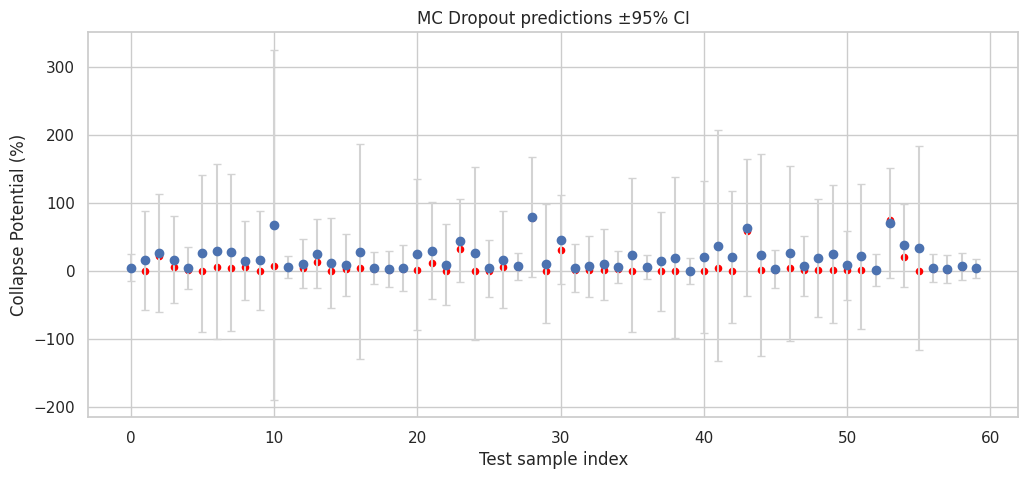

Fraction of actuals within MC 95% CI: 100.00%


In [21]:
# MC DROPOUT UNCERTAINTY (T runs)
p_drop = 0.2
mc_model = ANNModelDropout(INPUT_DIM, best_h1, best_h2, p_drop=p_drop).to(DEVICE)

# copy weights from final_model into mc_model where compatible
def copy_compatible_weights(src, tgt):
    s = src.state_dict(); t = tgt.state_dict()
    for k in t.keys():
        if k in s and s[k].shape == t[k].shape:
            t[k] = s[k].clone()
    tgt.load_state_dict(t)

copy_compatible_weights(final_model, mc_model)
mc_model.train()  # keep dropout active for stochastic forward passes

T = 100
mc_preds_scaled = np.zeros((T, X_test.shape[0]))
for t in range(T):
    with torch.no_grad():
        out_t = mc_model(X_test_tensor).cpu().numpy().flatten()
    mc_preds_scaled[t,:] = out_t

# inverse transform
mc_preds = scaler_y.inverse_transform(mc_preds_scaled.T).T  # (T, N)
mc_mean = mc_preds.mean(axis=0); mc_std = mc_preds.std(axis=0)
lower95 = mc_mean - 1.96*mc_std; upper95 = mc_mean + 1.96*mc_std

# plot first N points with CI
Nplot = min(60, X_test.shape[0])
plt.figure(figsize=(12,5))
plt.errorbar(np.arange(Nplot), mc_mean[:Nplot], yerr=1.96*mc_std[:Nplot], fmt='o', ecolor='lightgray', capsize=3)
plt.scatter(np.arange(Nplot), scaler_y.inverse_transform(y_test.reshape(-1,1)).flatten()[:Nplot], c='red', s=20)
plt.xlabel("Test sample index"); plt.ylabel("Collapse Potential (%)"); plt.title("MC Dropout predictions ±95% CI"); plt.show()

# calibration
actuals = scaler_y.inverse_transform(y_test.reshape(-1,1)).flatten()
frac_in = np.logical_and(actuals>=lower95, actuals<=upper95).mean()
print(f"Fraction of actuals within MC 95% CI: {frac_in*100:.2f}%")

In [24]:
# SAVE CHECKPOINT (GUI-ready)
torch.save({
    'model_class': 'ANNModel',
    'model_state_dict': final_model.state_dict(),
    'dropout_model_class': 'ANNModelDropout',
    'dropout_state_dict': mc_model.state_dict(),
    'params': {'h1':best_h1, 'h2':best_h2, 'lr':best_lr, 'p_drop':p_drop},
    'scaler_X': scaler_X,
    'scaler_y': scaler_y,
    'feature_names': feature_names,
    'ga_history': ga_hist,
    'fitness_heat_h1': h1_vals if 'h1_vals' in globals() else None,
    'fitness_heat_h2': h2_vals if 'h2_vals' in globals() else None,
    'fitness_heat_matrix': fitness_heat if 'fitness_heat' in globals() else None
    'X_test': X_test,   # numpy array or tensor
    'y_test': y_test,   # numpy array or tensor
}, SAVE_PATH)
print("Saved checkpoint to:", SAVE_PATH)

Saved checkpoint to: /content/drive/MyDrive/NNsGA/best_ga_ann_gui_ready_full.pth


In [59]:
# SAVE CHECKPOINT (GUI-ready)
torch.save({
    'model_class': 'ANNModel',
    'model_state_dict': final_model.state_dict(),
    'dropout_model_class': 'ANNModelDropout',
    'dropout_state_dict': mc_model.state_dict(),
    'params': {'h1':best_h1, 'h2':best_h2, 'lr':best_lr, 'p_drop':p_drop},
    'scaler_X': scaler_X,
    'scaler_y': scaler_y,
    'feature_names': feature_names,
    'ga_history': ga_hist,
    'fitness_heat_h1': h1_vals if 'h1_vals' in globals() else None,
    'fitness_heat_h2': h2_vals if 'h2_vals' in globals() else None,
    'fitness_heat_matrix': fitness_heat if 'fitness_heat' in globals() else None,
    'X_test': X_test,   # numpy array or tensor
    'y_test': y_test,   # numpy array or tensor
}, SAVE_PATH)
print("Saved checkpoint to:", SAVE_PATH)

Saved checkpoint to: /content/drive/MyDrive/NNsGA/best_ga_ann_gui_ready_full.pth


In [52]:
# Install ipywidgets for interactive UI
!pip install ipywidgets --quiet

import torch
import torch.nn as nn
import torch.serialization
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML
import ipywidgets as widgets

# Fix for unpickling complex checkpoint
torch.serialization.add_safe_globals([
    np._core.multiarray._reconstruct,
    np.dtype,
    MinMaxScaler,
])

In [60]:
# Load checkpoint path and device
ck_path = "/content/drive/MyDrive/NNsGA/best_ga_ann_gui_ready_full.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load full checkpoint (weights_only=False due to scalers and objects)
ck = torch.load(ck_path, map_location=device, weights_only=False)
print("Checkpoint loaded successfully!")


Checkpoint loaded successfully!


In [61]:
# Rebuild models
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.out = nn.Linear(hidden2, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

class ANNModelDropout(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, p=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.drop1 = nn.Dropout(p)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.drop2 = nn.Dropout(p)
        self.out = nn.Linear(hidden2, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        return self.out(x)

input_dim = len(ck['feature_names'])
params = ck['params']


In [62]:
# Load main model
model = ANNModel(input_dim, params['h1'], params['h2']).to(device)
model.load_state_dict(ck['model_state_dict'])
model.eval()

# Load dropout model for uncertainty
dropout_model = ANNModelDropout(input_dim, params['h1'], params['h2'], params.get('p_drop', 0.2)).to(device)
dropout_model.load_state_dict(ck['dropout_state_dict'])
dropout_model.eval()

# Load scalers and features
scaler_X = ck['scaler_X']
scaler_y = ck['scaler_y']
feature_names = ck['feature_names']

# Load test data if present
X_test = ck.get('X_test')
y_test = ck.get('y_test')


In [63]:
# Prediction functions

def predict_point(model, scaler_X, scaler_y, x_dict, feature_names):
    x = np.array([x_dict[name] for name in feature_names]).reshape(1,-1)
    xs = scaler_X.transform(x)
    xt = torch.tensor(xs, dtype=torch.float32).to(next(model.parameters()).device)
    with torch.no_grad():
        pred_scaled = model(xt).cpu().numpy().flatten()
    pred = scaler_y.inverse_transform(pred_scaled.reshape(-1,1)).flatten()[0]
    return float(pred)

def predict_with_uncertainty(dropout_model, scaler_X, scaler_y, x_dict, feature_names, T=100):
    x = np.array([x_dict[name] for name in feature_names]).reshape(1,-1)
    xs = scaler_X.transform(x)
    xt = torch.tensor(xs, dtype=torch.float32).to(next(dropout_model.parameters()).device)
    preds = []
    dropout_model.train()  # keep dropout active for MC dropout
    with torch.no_grad():
        for _ in range(T):
            out = dropout_model(xt).cpu().numpy().flatten()
            preds.append(out)
    preds = np.array(preds)
    preds_inv = scaler_y.inverse_transform(preds.reshape(-1,1)).flatten()
    mean = float(preds_inv.mean())
    std = float(preds_inv.std())
    lower95 = mean - 1.96*std
    upper95 = mean + 1.96*std
    dropout_model.eval()
    return {"mean": mean, "std": std, "95CI": (lower95, upper95)}


In [64]:
# Build interactive widgets

input_widgets = {}
for feat in feature_names:
    input_widgets[feat] = widgets.FloatText(
        description=feat,
        value=0.0,
        style={'description_width': '200px'},
        layout=widgets.Layout(width='400px')
    )

predict_button = widgets.Button(description="Predict (Manual Input)", button_style='success')
random_button = widgets.Button(description="Random Test Sample", button_style='info')
output_area = widgets.Output()

# --- Button callbacks ---

def on_predict_clicked(b):
    with output_area:
        output_area.clear_output()
        try:
            input_data = {f: input_widgets[f].value for f in feature_names}
            pred = predict_point(model, scaler_X, scaler_y, input_data, feature_names)
            unc = predict_with_uncertainty(dropout_model, scaler_X, scaler_y, input_data, feature_names, T=100)
            display(HTML(f"""
                <h4>Manual Input Prediction</h4>
                <p><b>Prediction:</b> {pred:.4f}</p>
                <p><b>Uncertainty (Std):</b> ±{unc['std']:.4f}</p>
                <p><b>95% Confidence Interval:</b> ({unc['95CI'][0]:.4f}, {unc['95CI'][1]:.4f})</p>
            """))
        except Exception as e:
            print("Error:", e)

def on_random_clicked(b):
    with output_area:
        output_area.clear_output()
        try:
            if X_test is None or y_test is None:
                print("Test set not available in checkpoint!")
                return
            idx = random.randint(0, len(X_test)-1)
            x_sample = X_test[idx]
            y_true = y_test[idx]
            x_dict = {f: float(val) for f, val in zip(feature_names, x_sample)}
            pred = predict_point(model, scaler_X, scaler_y, x_dict, feature_names)
            unc = predict_with_uncertainty(dropout_model, scaler_X, scaler_y, x_dict, feature_names, T=100)
            display(HTML(f"""
                <h4>Random Sample #{idx}</h4>
                <p><b>Features:</b> {x_dict}</p>
                <p><b>Prediction:</b> {pred:.4f}</p>
                <p><b>Actual:</b> {float(y_true):.4f}</p>
                <p><b>Uncertainty (Std):</b> ±{unc['std']:.4f}</p>
                <p><b>95% Confidence Interval:</b> ({unc['95CI'][0]:.4f}, {unc['95CI'][1]:.4f})</p>
            """))
        except Exception as e:
            print("Error:", e)

predict_button.on_click(on_predict_clicked)
random_button.on_click(on_random_clicked)

# Display UI
display(HTML("<h3>Neural Network + Genetics Algorithms Collapse Potential Prediction with Uncertainty</h3>"))
display(widgets.VBox(list(input_widgets.values()) + [predict_button, random_button, output_area]))
